In [1]:
%matplotlib inline

import os
import textwrap
import math

import datetime as dt
import pandas as pd

import matplotlib        as mpl
import matplotlib.pyplot as plt

import numpy             as np
import tables            as tb
import seaborn as sns

#import invisible_cities.core.core_functions as coref
#import invisible_cities.core.fit_functions  as fitf

from   scipy.optimize                          import curve_fit
from   scipy                                   import stats

#from   invisible_cities.io.dst_io import df_writer

# Formatting options
pd.options.display.max_columns = None
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['patch.force_edgecolor'] = False
mpl.rcParams['patch.facecolor'] = 'gray'
hargs = {'histtype': 'stepfilled', 'edgecolor': 'black', 'facecolor': 'gray'}

# Directory to which figures will be stored
#save_dir = "Plots Iniciales"
#ftype = "pdf"
#if(not os.path.isdir(save_dir)):
#    print("Creating directory",save_dir)
#    os.mkdir(save_dir)

In [2]:
evtfnames_data = ["/Users/diego/Desktop/DIEGO/USC/TFG/data/ntuple_combined_7746.h5"]
evtfnames_MC   = ["/Users/diego/Dropbox/NEXT/ntuple_combined_MC_6206.h5",
              "/Users/diego/Dropbox/NEXT/ntuple_combined_MC_6207.h5",
              "/Users/diego/Dropbox/NEXT/ntuple_combined_MC_6208.h5",]

In [19]:
cdf = None
for ifile,fname in enumerate(evtfnames_data):

    print("Adding file {} ...".format(fname))

    ftbl = tb.open_file(fname, 'r')
    
    fsummary = ftbl.root.Summary.Events
    fdst = ftbl.root.DST.Events
    ftracks = ftbl.root.Tracking.Tracks

    # Read the tables into DataFrames.
    to_df = pd.DataFrame.from_records
    df_summary = to_df(fsummary.read())
    df_tracks = to_df(ftracks.read())
    df_dst = to_df(fdst.read())
    
    # Drop duplicates in the KDST, selecting the S1 and S2 with highest energy.
    df_dst1 = df_dst.sort_values(['event','S1e','S2e'])[['event','S2e','S1e','nS1','nS2']].drop_duplicates('event',keep='last')
    
    # Drop duplicates in the TDST, selecting the longest tracks.
    df_tracks = df_tracks.sort_values(['event','length','energy']).drop_duplicates('event',keep='last')
    
    # Merge into a single dataframe.
    df_merge = pd.merge(df_summary, df_dst1, on = 'event', how='left')
    df_merge = pd.merge(df_merge, df_tracks, on = 'event', how='left')
    
    # Concatenate with previous runs.
    if(cdf is None):
        cdf = df_merge
    else:
        cdf = cdf.append(df_merge)
        
    ftbl.close()

A_evtnum    = cdf['event'].values
A_maxtrklen = cdf['length'].values
A_maxtrkenergy = cdf['energy'].values
A_ntrks     = cdf['evt_ntrks'].values
A_nhits     = cdf['evt_nhits'].values
A_Ec        = cdf['evt_energy'].values
A_xavg      = cdf['evt_x_avg'].values
A_yavg      = cdf['evt_y_avg'].values
A_zavg      = cdf['evt_z_avg'].values
A_ravg      = cdf['evt_r_avg'].values
A_xmin      = cdf['evt_x_min'].values
A_ymin      = cdf['evt_y_min'].values
A_zmin      = cdf['evt_z_min'].values
A_xmax      = cdf['evt_x_max'].values
A_ymax      = cdf['evt_y_max'].values
A_zmax      = cdf['evt_z_max'].values
A_rmin      = cdf['evt_r_min'].values
A_rmax      = cdf['evt_r_max'].values
A_nS1       = cdf['nS1'].values
A_S2e       = cdf['S2e'].values

print("{} total events".format(len(A_evtnum)))
cdf.head(10)

Adding file /Users/diego/Desktop/DIEGO/USC/TFG/data/ntuple_combined_7746.h5 ...
596443 total events


,event,evt_energy,evt_charge,evt_ntrks,evt_nhits,evt_x_avg,evt_y_avg,evt_z_avg,evt_r_avg,evt_x_min,evt_y_min,evt_z_min,evt_r_min,evt_x_max,evt_y_max,evt_z_max,evt_r_max,evt_out_of_map,S2e,S1e,nS1,nS2,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,r_min,x_max,y_max,z_max,r_max,x_ave,y_ave,z_ave,r_ave,extreme1_x,extreme1_y,extreme1_z,extreme2_x,extreme2_y,extreme2_z,blob1_x,blob1_y,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,7,0.335598,-1.0,1,36,-135.649480,-27.828993,155.537656,138.684092,-155.0,-45.0,152.674953,125.896783,-125.0,-15.0,157.736506,157.003185,False,84618.867188,81.997467,1,1,0.0,0.335598,20.000000,4.0,32.0,1.0,-145.0,-45.0,152.674953,127.475488,-125.0,-15.0,157.736506,151.822265,-135.688308,-27.876997,155.553153,138.721372,-140.0,-40.0,155.205729,-140.0,-20.0,155.205729,-138.276759,-15.000000,155.982208,-137.166530,-45.000000,155.538388,0.269277,0.211121,0.144800,10.0,10.0,10.0
1,20,0.449683,-1.0,1,58,11.388019,168.250244,244.763036,168.786497,-5.0,155.0,238.861932,155.080624,25.0,185.0,249.482353,186.681547,False,86366.273438,109.920044,1,1,0.0,0.449683,24.142136,7.0,53.0,1.0,-5.0,155.0,238.861932,155.080624,25.0,185.0,249.482353,185.607112,11.255903,168.256899,244.789971,168.777191,10.0,160.0,239.172142,10.0,180.0,249.172142,9.917869,155.000000,241.562674,11.246521,185.000000,247.142565,0.325202,0.258931,0.134450,10.0,10.0,10.0
2,21,0.231753,-1.0,1,30,-47.572942,-2.542974,332.936846,48.134566,-65.0,-15.0,329.015076,35.355339,-35.0,15.0,335.901912,65.192024,False,61307.527344,68.129738,1,1,0.0,0.231753,14.142136,3.0,28.0,1.0,-55.0,-15.0,329.015076,35.355339,-35.0,5.0,335.901912,57.008771,-47.420587,-2.704913,332.936846,47.947807,-50.0,-10.0,332.458494,-40.0,0.0,332.458494,-49.351206,-15.000000,332.672652,-35.000000,-1.618100,332.286847,0.222574,0.195540,0.186361,10.0,10.0,10.0
3,28,NaN,-1.0,1,190,NaN,NaN,NaN,NaN,-205.0,-5.0,269.224555,105.118980,-105.0,55.0,334.883022,206.518764,True,304383.781250,463.642334,1,1,0.0,1.285731,107.566304,50.0,172.0,1.0,-195.0,5.0,271.048179,115.108644,-115.0,55.0,334.883022,198.116128,-154.418321,24.564391,299.920690,156.683581,-190.0,10.0,272.965600,-120.0,10.0,332.965600,-115.000000,5.000000,331.306863,-195.000000,5.000000,273.405236,0.262475,0.135371,0.000000,10.0,10.0,10.0
4,35,0.247732,-1.0,1,28,-33.095697,127.828766,132.349715,132.191430,-45.0,115.0,130.127083,117.686023,-25.0,145.0,134.995363,149.164339,False,57483.855469,63.679695,1,1,0.0,0.247732,20.000000,4.0,27.0,1.0,-45.0,115.0,130.127083,117.686023,-25.0,145.0,134.995363,149.164339,-33.042761,127.891975,132.349715,132.233231,-30.0,120.0,132.561223,-30.0,140.0,132.561223,-32.572454,115.000000,131.959763,-32.138881,145.000000,132.387060,0.203896,0.162763,0.118927,10.0,10.0,10.0
5,36,0.673615,-1.0,3,65,11.179454,-102.109449,80.439623,121.902260,-95.0,-135.0,46.697253,85.146932,65.0,-65.0,156.099862,145.773797,False,117246.187500,149.008453,1,3,0.0,0.463005,28.284271,8.0,37.0,3.0,45.0,-125.0,46.697253,109.772492,65.0,-95.0,53.570186,140.890028,53.355770,-116.387457,49.431177,128.185570,40.0,-100.0,51.398558,60.0,-120.0,51.398558,45.000000,-105.000000,48.815801,65.000000,-125.000000,51.011344,0.320124,0.313478,0.170597,10.0,10.0,10.0
6,40,NaN,-1.0,2,39,NaN,NaN,NaN,NaN,-205.0,-15.0,84.880696,175.071414,-175.0,15.0,118.325394,205.548048,True,61498.367188,77.302223,1,2,0.0,0.235160,20.000000,4.0,23.0,2.0,-195.0,-15.0,84.880696,175.071414,-175.0,15.0,91.523051,195.576072,-192.494127,-0.874157,88.275109,192.625493,-190.0,-10.0,86.603045,-190.0,10.0,86.603045,-195.000000,-15.000000,88.422722,-195.000000,15.000000,87.597674,0.192950,0.187941,0.147778,10.0,10.0,10.0
7,52,0.328221,-1.0,1,39,48.967914,2.607150,267.176805,49.555593,35.0,-15.0,263.610989,35.355339,65.0,15.0,270.512300,66.708320,False,85002.062500,98.218796,1,1,0.0,0.328221,20.000000,4.0,35.0,1.0,35.0,-5.0,263.610989,35.355339,65.0,15.0,270.512300,65.192024,48.965581,2.741124,267.

# Porcentaxe Número de S2 

Hago un histograma que me permita ver el número de pulsos S2 que hay en los eventos que estamos analizando. Podemos ver que predominan los eventos con nS2 = 1, pero también aparecen algunos con 2, 3 o incluso 4 pulsos S2.

|    S2           |    %    | 
| --------------- | ------- |
| 1               | 78.315% |
| 2               | 18.097% |
| 3               | 3.048%  |
| 4               | < 1%    |
| 5, 6, 7, 8 e 9  | < 1%    |

INFORMACIÓN XENERAL SOBRE S2
DescribeResult(nobs=596443, minmax=(1, 11), mean=1.2589417597322796, variance=0.29049261933248816, skewness=2.3176891056794253, kurtosis=6.518163160543951)


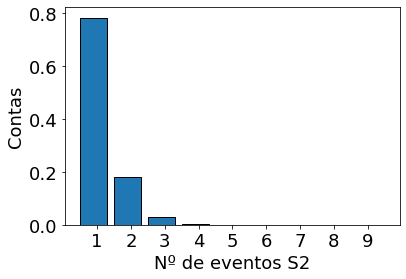

In [32]:
bins = np.arange(start=1, stop=11) - 0.5

#HISTOGRAMA
n, bins, patches = plt.hist(cdf.nS2, bins, edgecolor='black', width=0.8, density = True)
plt.xticks(np.arange(start=1, stop=10))
plt.xlabel('Nº de eventos S2')
plt.ylabel('Contas')

#CREO LOS PORCENTAJES
#x = stats.describe(cdf.nS2)
#a = []
#for i in range(len(n)):
#    a.append((n[i]/x[0])*100)
    
print('INFORMACIÓN XENERAL SOBRE S2')
print(stats.describe(cdf.nS2))
#print('')
#print('COUNTS')
#print('1 S2: {:.3f}%; 2 S2: {:.3f}%; 3 S2: {:.3f}%; 4 S2: {:.3f}%; 5 S2: {:.3f}%;'
#      ' 6 S2: {:.3f}%; 7 S2: {:.3f}%; 8 S2: {:.6f}%; 9 S2: {:.6f}%'.format(a[0],a[1],a[2],a[3],a[4],
#                                                                                    a[5],a[6],a[7],a[8]))

# Nº de S2 == 1

INFORMACIÓN XENERAL SOBRE AS TRAZAS
DescribeResult(nobs=467103, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)

CONTAS
nS2 == 1 & nTr == 1 --> 94.832% 
nS2 == 1 & nTr == 2 --> 4.672% 
nS2 == 1 & nTr == 3 --> 0.416%
nS2 == 1 & nTr == 4 --> 0.065%


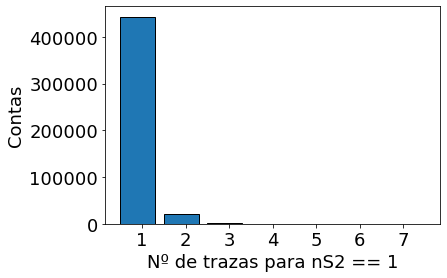

In [27]:
#PRIMER CORTE
one_S2 = cdf[(cdf.nS2 == 1)]

bins = np.arange(start=1, stop=9) - 0.5
n, bins, patches = plt.hist(one_S2.numb_of_tracks, bins, edgecolor='black', width=0.8)
plt.xticks(np.arange(start=1, stop=8))
plt.xlabel('Nº de trazas para nS2 == 1')
plt.ylabel('Contas')

x = stats.describe(one_S2.numb_of_tracks)
a = []
for i in range(len(n)):
    a.append((n[i]/x[0])*100)

b = np.sum(a[1:])

print('INFORMACIÓN XENERAL SOBRE AS TRAZAS')
print(x)
print('')
print('CONTAS')
print('nS2 == 1 & nTr == 1 --> {:.3f}% \nnS2 == 1 & nTr == 2 --> {:.3f}% \nnS2 == 1 & nTr == 3 --> {:.3f}%'
      '\nnS2 == 1 & nTr == 4 --> {:.3f}%'.format(a[0], a[1], a[2], a[3]))

# Nº de S2 == 2

INFORMACIÓN XENERAL SOBRE AS TRAZAS
DescribeResult(nobs=107940, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)

CONTAS
nS2 == 2 & nTr == 1 --> 34.744% 
nS2 == 2 & nTr == 2 --> 60.284%, 
nS2 == 2 & nTr == 3 --> 4.513%
nS2 == 2 & nTr == 4 --> 0.373%, 
nS2 == 2 & nTr == 5 --> 0.056%, 
nS2 == 2 & nTr == 6 --> 0.008%
nS2 == 2 & nTr == 7 --> 0.005%


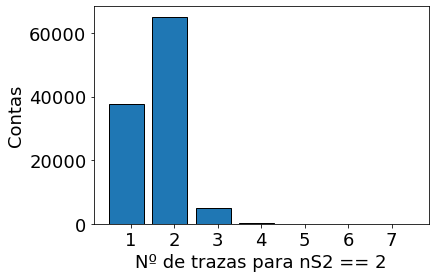

In [22]:
two_S2 = cdf[(cdf.nS2 == 2)]

bins = np.arange(start=1, stop=9) - 0.5
n, bins, patches = plt.hist(two_S2.numb_of_tracks, bins, edgecolor='black', width=0.8)
plt.xticks(np.arange(start=1, stop=8))
plt.xlabel('Nº de trazas para nS2 == 2')
plt.ylabel('Contas')

x = stats.describe(two_S2.numb_of_tracks)
a = []
for i in range(len(n)):
    a.append((n[i]/x[0])*100)

b = np.sum(a) - a[1]

print('INFORMACIÓN XENERAL SOBRE AS TRAZAS')
print(x)
print('')
print('CONTAS')
print('nS2 == 2 & nTr == 1 --> {:.3f}% \nnS2 == 2 & nTr == 2 --> {:.3f}%, \nnS2 == 2 & nTr == 3 --> {:.3f}%'
      '\nnS2 == 2 & nTr == 4 --> {:.3f}%, \nnS2 == 2 & nTr == 5 --> {:.3f}%, \nnS2 == 2 & nTr == 6 --> {:.3f}%'
      '\nnS2 == 2 & nTr == 7 --> {:.3f}%'.format(a[0], a[1], a[2], a[3], a[4], a[5], a[6]))

# Nº de S2 > 2

INFORMACIÓN XENERAL SOBRE AS TRAZAS
DescribeResult(nobs=21400, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)

CONTAS
nS2 > 2 & nTr == nS2 --> 39.575% 
nS2 > 2 & nTr != nS2 --> 60.425%


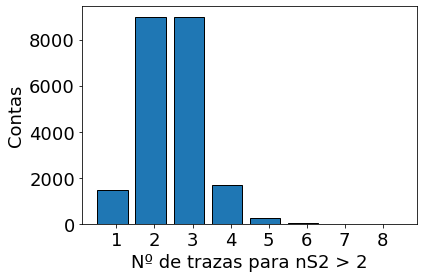

In [23]:
large_S2 = cdf[(cdf.nS2 > 2)]

bins = np.arange(start=1, stop=10) - 0.5
n, bins, patches = plt.hist(large_S2.numb_of_tracks, bins, edgecolor='black', width=0.8)
plt.xticks(np.arange(start=1, stop=9))
plt.xlabel('Nº de trazas para nS2 > 2')
plt.ylabel('Contas')


e = 0
d = 0

for i, j in zip(large_S2.nS2,large_S2.numb_of_tracks):
    if i == j:
        e += 1
    else:
        d += 1
        
f = e/len(large_S2.numb_of_tracks)*100
g = d/len(large_S2.numb_of_tracks)*100


print('INFORMACIÓN XENERAL SOBRE AS TRAZAS')
print(stats.describe(large_S2.numb_of_tracks))
print('')
print('CONTAS')
print('nS2 > 2 & nTr == nS2 --> {:.3f}% \nnS2 > 2 & nTr != nS2 --> {:.3f}%'.format(f, g))

# Resultados Para Datos *Monte Carlo*

Presentamos en esta tabla los resultados del análisis del número de S2 frente al número de trazas, que nos proporciona resultados en un principio desconcertantes como, por ejemplo, que para eventos en los que nS2 == 2 tengamos exclusivamente una traza.

| nS2 \ nTr   | 1       | 2       | 3        | 4      | 5    | 6    | 7    |  
| ----------- | ------- | ------- | -------- | ------ | ---- | ---- | ---- |
| 1           | 77.795% | 17.888% | 3.614%   | < 1%   | < 1% | < 1% | < 1% |
| 2           | 16.502% | 65.885% | 14. 833% | 2.409% | < 1% | < 1% | < 1% |

A mayores, tenemos como generalización de la tabla anterior otra en la que establecemos una relación más general. Esta vez comparamos los eventos en los que coinciden o difieren nS2 y el número de trazas para ese mismo evento (para nS2 > 2).

| nS2 \ nTr   | == nS2  | != nS2  |
| ----------- | ------- | ------- |
| > 2         | 42.511% | 57.489% |

# Resultados Para Datos *Reales*

Presentamos en esta tabla los resultados del análisis del número de S2 frente al número de trazas, que nos proporciona resultados en un principio desconcertantes como, por ejemplo, que para eventos en los que nS2 == 2 tengamos exclusivamente una traza.

| nS2 \ nTr   | 1       | 2       | 3        | 4      | 5    | 6    | 7    |  
| ----------- | ------- | ------- | -------- | ------ | ---- | ---- | ---- |
| 1           | 94.832% |  4.672% | < 1%     | < 1%   | < 1% | < 1% | < 1% |
| 2           | 34.744% | 60.284% | 4.513%   | < 1%   | < 1% | < 1% | < 1% |

A mayores, tenemos como generalización de la tabla anterior otra en la que establecemos una relación más general. Esta vez comparamos los eventos en los que coinciden o difieren nS2 y el número de trazas para ese mismo evento (para nS2 > 2).

| nS2 \ nTr   | == nS2  | != nS2  |
| ----------- | ------- | ------- |
| > 2         | 39.575% | 60.425% |